# TPT pipeline with ERA5 and S2S

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import matplotlib
from matplotlib import ticker
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LinearRegression
import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs

In [3]:
%load_ext autoreload

In [4]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils
%aimport tdmc_obj

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

# Set up experiment

Algorithmic parameters

In [7]:
max_delay = 15
num_clusters = 170
clust_bndy_choice = "half"

Which tasks to do

In [8]:
compute_eofs_flag =                   0
plot_eofs_flag =                      0
compute_all_features_flag =           0
assemble_tpt_features_flag =          0
extreme_value_analysis_flag =         0
path_counting_flag =                  0
build_msm_flag =                      0
dga_flag =                            0
featset =                             1 # n, where this is the n'th set of features we've tried

In [9]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-09-03"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-09-03"),
                #"filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-09-05",),
                #"filename": "era5_features_tpt.nc",
            }),
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "s2s_data", "stats", "2022-09-04"),
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "s2s_data", "features_all", "2022-09-03"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "s2s_data", "features_tpt", "2022-09-05",),
                "filename": "s2s_features_tpt.nc",
            }),
        })    
    }),
    "results": dict({
        "dir": join(
            topic_dir, "results", "tpt_quantities", "2022-09-25", 
            f"del{max_delay}_cls{num_clusters}_bdy{clust_bndy_choice}_featset{featset}")
    })
})
dispdict = dict({
    "e5": dict({
        "color": "dodgerblue",
        "abbrv": "ERA5",
    }),
    "s2": dict({
        "color": "red",
        "abbrv": "S2S",
    }),
    "linear_model": dict({
        "color": "gray",
        "abborv": "Linear model",
    })
})

In [10]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

# Define EOFs

Compute from data between October and March

In [ ]:
if compute_eofs_flag:
    trajdir = filedict["data"]["e5"]["traj"]["dir"]
    file_list = [join(trajdir, f) for f in os.listdir(trajdir)]
    ds_eofs, ds_monclim = xr_utils.compute_eofs(file_list, "e5", months_of_interest = [10, 11, 12, 1, 2, 3])
    statsdir = filedict["data"]["e5"]["stats"]["dir"]
    eofdir = filedict["data"]["e5"]["stats"]["dir"]
    ds_eofs.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
    ds_eofs.close()
    ds_monclim.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))
    ds_monclim.close()

Reload and plot them 

In [ ]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_monclim = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))
ds_eofs.close()
ds_monclim.close()

if plot_eofs_flag:
    fig = matplotlib.pyplot.figure(figsize=(24,18))
    eofs, variance_fraction = ds_eofs["eofs"], ds_eofs["variance_fraction"]
    for i_lev in range(4):
        # Plot singular value spectrum
        ax = fig.add_subplot(3,4,i_lev+1)
        vf = variance_fraction.isel(level=i_lev)
        ax.plot(variance_fraction.mode, 100*variance_fraction.isel(level=i_lev), marker='o', color='black')
        ax.set_xlabel("Mode")
        ax.set_ylabel("Variance percentage")
        ax.set_title(f"{variance_fraction.level.data[i_lev]} hPa", font={"size": 30})
        # Plot EOF 1
        ax = fig.add_subplot(3,4,4+i_lev+1,projection=ccrs.Orthographic(-10,90))
        xr_utils.display_pole_field(eofs.sel(mode=1).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
        ax.set_title("EOF 1")
        # Plot EOF 2
        ax = fig.add_subplot(3,4,8+i_lev+1,projection=ccrs.Orthographic(-10,90))
        xr_utils.display_pole_field(eofs.sel(mode=2).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
        ax.set_title("EOF 2")


## Read database and compute features. 

In [11]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

Specify any feature definitions, such as for computing EOFs. But for the most part, these features are straightforward observables with original physical units and no normalization. 

In [12]:
#featdef = {"ds_eofs": ds_eofs, "ds_monclim": ds_monclim}

In [13]:
if compute_all_features_flag:
    obs2compute = [
        "time_observable", "ubar_observable", #"pc_observable", 
        "temperature_observable", "heatflux_observable",
        "qbo_observable",
    ]
    for src in ["e5","s2"]:
        obs_dict = dict({obsname: [] for obsname in obs2compute})
        input_dir = filedict["data"][src]["traj"]["dir"]
        input_file_list = [f for f in os.listdir(input_dir) if f.endswith(".nc")]
        output_dir = filedict["data"][src]["feat_all"]["dir"]
        feat_strat.compute_all_features(
            src, input_dir, input_file_list, output_dir, 
            featdef, obs2compute=obs2compute
        )

Reload the TPT features as a dictionary. We don't yet put them in a single dataset in order to avoid dimension conflicts. 

In [14]:
feat_all = dict()
for src in ["s2","e5"]:
    feat_all[src] = feat_strat.assemble_all_features(
        src,
        filedict["data"][src]["feat_all"]["dir"]
        )

Plot some climatological envelopes, as well as some hindcast ensembles from the same year 

[  0  30  61  91 122 153 181 212 242 273 303 334]


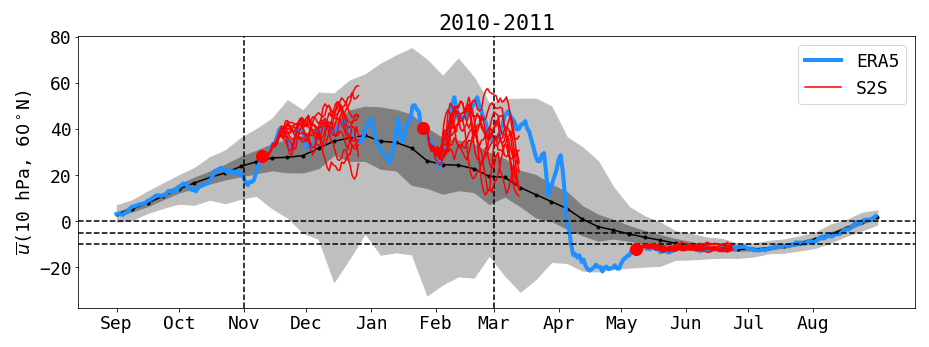

In [177]:
fig,ax = plt.subplots(figsize=(15,5))
fig.set_facecolor("white")
handles = []

year2plot = 2010
obs_group = "ubar_observable"
obs_name = "ubar_10_60"
obs_label = "$\overline{u}$(10 hPa, $60^\circ$N)"
t_init_target_list = [70, 147.0, 250] # How many days into the season

cond_e5 = 1*(feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == year2plot)
cond_s2 = 1*(feat_all["s2"]["time_observable"].isel(t_sim=0).sel(feature="year_szn_start") == year2plot)

t_szn_1year = feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy()
xticks, xticklabels = feat_strat.generate_seasonal_xticks(t_szn_1year)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_title(f"{year2plot}-{year2plot+1}")

tpt_utils.plot_field_1d(
    feat_all["e5"][obs_group].sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(), 
    np.ones(feat_all["e5"][obs_group].t_sim.size), 
    feat_all["e5"]["time_observable"].sel(feature="t_szn").isel(t_init=0,member=0).to_numpy(),
    feat_name="", field_name=obs_label,
    fig=fig, ax=ax, nbins=50
)

h, = ax.plot(
    t_szn_1year,
    feat_all["e5"][obs_group].where(cond_e5,drop=True).sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(),
    color='dodgerblue', linewidth=4, label="ERA5"
)
handles += [h]
ax.legend(handles=handles)
fig.savefig(join(filedict["results"]["dir"], f"{year2plot}_illust_0"))

# Draw thresholds
for uth in [0,-5,-10]:
    ax.axhline(y=uth, color='black', linestyle='--')
ax.axvline(x=61, color='black', linestyle='--')
ax.axvline(x=181, color='black', linestyle='--')
fig.savefig(join(filedict["results"]["dir"], f"{year2plot}_illust_1"))


t_szn_1year = feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy()
for t_init_target in t_init_target_list:
    i_t_init = int(t_init_target / 3.5)
    for i_mem in range(feat_all["s2"]["time_observable"].member.size):
        x_ens, = (
            feat_all["s2"]["time_observable"].where(cond_s2,drop=True)
            .isel(t_init=i_t_init,member=i_mem)
            .sel(feature="t_szn").to_numpy()
        ),
        y_ens, = feat_all["s2"][obs_group].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature=obs_name).to_numpy(),
        h, = ax.plot(x_ens, y_ens, color='red', label="S2S")
        if i_mem == 0: 
            h = ax.scatter(x_ens[0], y_ens[0], color='red', marker='o', zorder=10, s=144)

handles += [h]
ax.legend(handles=handles)

fig.savefig(join(filedict["results"]["dir"], f"{year2plot}_illust_2"))

Plot some two-dimensional densities, at multiple time slices throughout the season.

# Assemble features for TPT.

Assemble and save the features with time delays. 

In [16]:
if assemble_tpt_features_flag:
    for src in ["s2","e5"]:
        feat_strat.assemble_tpt_features(feat_all[src], filedict["data"][src]["feat_tpt"]["dir"])

Reload them

In [17]:
feat_tpt = dict()
for src in ["s2","e5"]:
    feat_tpt[src] = xr.open_dataarray(join(filedict["data"][src]["feat_tpt"]["dir"], "features_tpt.nc"))

# Plot some densities to get a feel for the data

Two-dimensional histograms of various observables

In [18]:
src = "s2"
feats2plot = ["ubar_10_60_delay0","vT_100_1_runavg10"]
cond = 1*(
    (feat_tpt[src].sel(feature="t_szn") > 0) * 
    (feat_tpt[src].sel(feature="t_szn") < 100)
)
feat_names = ["U1060","vT 10-day mean"]
data_cond = feat_tpt[src].where(cond)
data_cond = data_cond.sel(feature=feats2plot,drop=True)
data_cond = data_cond.stack(snapshot=("t_init","member","t_sim"))

In [ ]:
fig,ax = plt.subplots()
tpt_utils.plot_field_2d(
    np.ones(data_cond.snapshot.size), 
    np.ones(data_cond.snapshot.size),
    np.array([
        data_cond.sel(feature=feats2plot[0]).to_numpy().flatten(), 
        data_cond.sel(feature=feats2plot[1]).to_numpy().flatten()
    ]).T,
    feat_names = feat_names,
    fig=fig, ax=ax, shp=[25,25],
    stat_name="weightsum", 
    cmap=plt.cm.magma, logscale=True
)

# Return time estimates: three methods 

In the following, we sweep through a number of SSW definitions, varying both the threshold and the season. 

In [20]:
sep1 = 0
oct1,nov1,dec1,jan1 = np.cumsum([monthrange(1901,m)[1] for m in [9,10,11,12]])
feb1,mar1,apr1 = jan1 + np.cumsum([monthrange(1902,m)[1] for m in [1,2,3]])
u_thresh_list = np.arange(-52,1,4)
t_thresh_list = np.array([
    [oct1, apr1],
    [nov1, mar1],
    [oct1, mar1],
])[:2]
t_thresh_string_list = [
    "Oct-Mar", "Nov-Feb", 
]
np.save(join(filedict["results"]["dir"], "u_thresh_list"), u_thresh_list)
np.save(join(filedict["results"]["dir"], "t_thresh_list"), u_thresh_list)

## Method 1: extreme value theory

In [ ]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [ ]:
if extreme_value_analysis_flag:
    feat_strat.extreme_value_analysis(t_thresh_list, feat_tpt, filedict["results"]["dir"])

## Plot results (just the linear model)

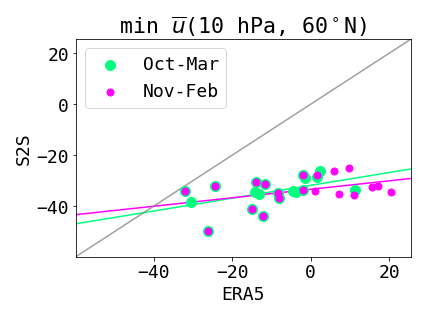

In [21]:
fig,ax = plt.subplots()
fig.set_facecolor("white")
xlim = np.inf*np.array([1,-1])

itth_list = [0,1,2]
sizes = [100, 49, 9]
zorders = [1, 2, 3]
colors = ['springgreen', 'magenta', 'black']

handles = []
for i_tth in range(len(t_thresh_list)):
    t_thresh = t_thresh_list[i_tth]
    extval_stats = pickle.load(open(join(filedict["results"]["dir"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
    fyidx = dict({
        "e5": np.where(np.in1d(extval_stats["e5"]["fall_years"], extval_stats["s2"]["fall_years"])),
        "s2": np.where(np.in1d(extval_stats["s2"]["fall_years"], extval_stats["e5"]["fall_years"]))
    })
    fy_common = extval_stats["e5"]["fall_years"][fyidx["e5"]]
    # Plot minimum S2S vs minimum E5
    xdata = extval_stats["e5"]["umin"][fyidx["e5"]]
    ydata = extval_stats["s2"]["umin"][fyidx["s2"]]
    xlim = [min(xlim[0], xdata.min(), ydata.min()) - 5, max(xlim[1], xdata.max(), ydata.max()) + 5]
    h = ax.scatter(xdata, ydata, s=sizes[i_tth], color=colors[i_tth], marker='o', zorder=zorders[i_tth], label=t_thresh_string_list[i_tth])
    handles += [h]
# Plot the linear model
for i_tth in range(len(t_thresh_list)):
    t_thresh = t_thresh_list[i_tth]
    extval_stats = pickle.load(open(join(filedict["results"]["dir"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
    intercept,slope = extval_stats["linear_model"]["coeffs"]
    ax.plot(np.array(xlim), intercept + slope*np.array(xlim), color=colors[i_tth], zorder=-1)

ax.set_title(r"min $\overline{u}$(10 hPa, 60$^\circ$N)")
ax.set_xlabel("ERA5")
ax.set_ylabel("S2S")
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.plot(xlim, xlim, color='gray', zorder=-1, alpha=0.75)
ax.legend(handles=handles)

fig.savefig(join(filedict["results"]["dir"], "umin_s2_vs_e5"), bbox_inches="tight")


## Method 2: count paths from each initialization

In [22]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [23]:
if path_counting_flag:
    for i_tth in range(len(t_thresh_list)):
        t_thresh = t_thresh_list[i_tth]
        rate_e5,rate_s2 = feat_strat.path_counting_rates(feat_all, feat_tpt, t_thresh, u_thresh_list)
        rate_e5.to_netcdf(join(filedict["results"]["dir"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
        rate_s2.to_netcdf(join(filedict["results"]["dir"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

## Plot results

Text(0.5, 0.98, 'Nov-Feb')

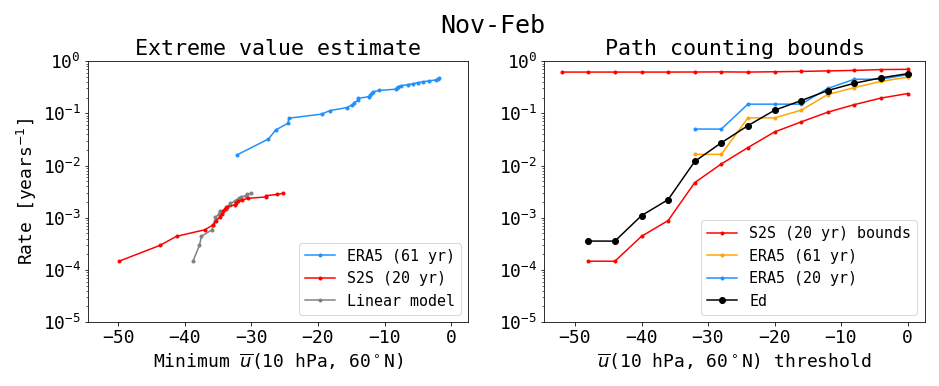

In [24]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]
extval_stats = pickle.load(open(join(filedict["results"]["dir"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
rate_e5 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

fig,axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True, sharex=True)
fig.set_facecolor("white")
axes[1].yaxis.set_tick_params(labelbottom=True)

# First plot: extreme values
ax = axes[0]
labels = {"e5": "ERA5 (61 yr)", "s2": "S2S (20 yr)", "linear_model": "Linear model"}
zorders = {"e5": 0, "s2": 1, "linear_model": -1}
handles = []
for src in ["e5","s2","linear_model"]:
    idx, = np.where(extval_stats[src]["umin"] < 0)
    order = np.argsort(extval_stats[src]["umin"][idx])
    h, = ax.plot(
        extval_stats[src]["umin"][idx][order], extval_stats[src]["rate_lower"][idx][order], 
        color=dispdict[src]["color"],
        marker='.', label=labels[src], zorder=zorders[src]
    ) 
    handles += [h]


ax.legend(handles=handles, fontsize="small", loc="lower right")
ax.set_xlabel("Minimum $\overline{u}$(10 hPa, 60$^\circ$N)")
ax.set_ylabel("Rate [years$^{-1}$]")
ax.set_yscale("log")
ax.set_title("Extreme value estimate")

# Second plot: rates
ax = axes[1]
handles = []
rate_s2 = rate_s2.where(rate_s2 > 0)
#colors = ["red", "purple", "orange"]
ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower"), color="red", marker='.')
h, = ax.plot(
    rate_s2["u_thresh"], rate_s2.sel(bound="upper"), 
    color="red", marker='.', label=r"S2S (20 yr) bounds"
)
handles += [h]
# Additionally plot ERA5 only
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), color="orange", marker='.', label="ERA5 (61 yr)")
handles += [h]
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), color="dodgerblue", marker='.', label="ERA5 (20 yr)")
handles += [h]

# Additionally plot Ed's estimate
h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed"), color="black", marker="o", label="Ed")
handles += [h]

ax.set_yscale("log")
ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold")
ax.legend(handles=handles, fontsize="small")
ax.set_title("Path counting bounds")
ax.set_ylim([1e-5,1])

fig.subplots_adjust(top=0.85)
fig.suptitle(t_thresh_string_list[i_tth], y=0.98, fontsize=25)

# Method 3: running a LIM 

Here we construct a linear inverse model (a.k.a., (E)DMD) from the features we've chosen. We will test its robustness to lag time and ensure it varies smoothly with the seasonal cycle. After that, we will possibly incorporate the corresponding modes into the feature vector for DGA. 

In [114]:
ubar_names = [f"ubar_{lev}_60_delay{d}" for d in [0] for lev in [10,100,500,850]]
vT_1_names = [f"vT_{lev}_1_runavg10" for lev in [10,100,500,850]]
vT_2_names = [f"vT_{lev}_2_runavg10" for lev in [10,100,500,850]]
ubar_delay_names = [f"ubar_10_60_delay{d}" for d in range(15)]
#lim_feature_names = ubar_names + vT_1_names + vT_2_names
lim_feature_names = ubar_delay_names
feat_msm = feat_tpt["s2"].sel(feature=lim_feature_names)
feat_msm_e5 = feat_tpt["e5"].sel(feature=lim_feature_names)

In [115]:
szn_stats_e5 = feat_strat.get_seasonal_statistics(feat_msm_e5, feat_tpt["e5"].sel(feature="t_szn"))
# Replace the mean with first four harmonics
ssm = szn_stats_e5["mean"].transpose("feature","t_szn_cent")
ssmhat = np.fft.fft(ssm.values, axis=1)
ssmhat[:,5:-5] = 0
ssmooth = np.fft.ifft(ssmhat, axis=1).real
ssm[:] = ssmooth

In [116]:
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [117]:
feat_lim = dict()
for src in ["s2","e5"]:
    feat_lim[src] = feat_tpt[src].sel(feature=lim_feature_names)

In [118]:
lim = dict()
for src in ["s2","e5"]:
    lim[src] = feat_strat.build_lim(
        feat_lim[src], szn_stats_e5, feat_all[src]["time_observable"], 
        max_delay, demean=True, max_lag=1
    )

Simulate the LIM!

In [119]:
# Sample random initial conditions
win_init = 0
win_fin = 260
szn_window_e5 = (feat_all["e5"]["time_observable"].sel(feature="t_szn") / feat_strat.dt_szn).astype(int)
feat_lim_e5 = feat_lim_e5.transpose("t_init","member","t_sim","feature")
idx_init = np.where(szn_window_e5.values == win_init)
X_init = (
    feat_lim["e5"].transpose("t_init","member","t_sim","feature")
    - szn_stats_e5["mean"].isel(t_szn_cent=win_init)
).values[idx_init]

In [145]:
# Run both LIMs 
X_sim = dict()
for src in ["e5","s2"]:
    X_sim[src] = xr.DataArray(
        coords={
            "t_szn_cent": szn_stats_e5["t_szn_cent"].values[win_init:win_fin+1], 
            "feature": feat_lim["e5"]["feature"],
            "sample": np.arange(30000),
        },
        dims=["t_szn_cent","sample","feature"],
        data=np.nan,
    )
    idx_sim = np.random.choice(np.arange(len(X_init)), size=X_sim[src]["sample"].size, replace=True)
    X_sim[src][dict(t_szn_cent=0)] = X_init[idx_sim]

    for i_win in range(win_fin-win_init):
        xi = np.random.randn(X_sim[src]["sample"].size, X_sim[src]["feature"].size)
        forcing = xi @ (lim[src]["sigma"].isel(t_szn_cent=win_init+i_win).values).T
        G = lim[src]["G"].isel(t_szn_cent=win_init+i_win).values
        X_sim[src][dict(t_szn_cent=i_win+1)] = X_sim[src].isel(t_szn_cent=i_win).values @ G.T + forcing

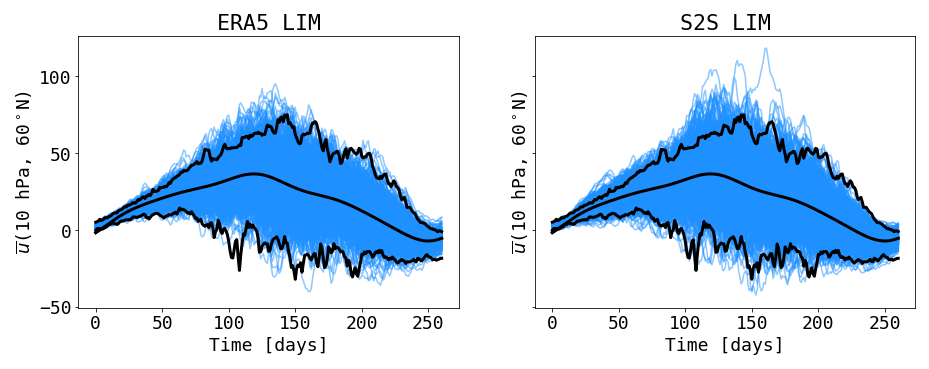

In [164]:
feat = "ubar_10_60_delay0"
fig,axes = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
sources = ["e5","s2"]
for i_src,src in enumerate(["e5","s2"]):
    ax = axes[i_src]
    ax.plot(szn_stats_e5["mean"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    for samp in range(500): #X_sim["sample"].values:
        ax.plot(
            X_sim[src].sel(sample=samp,feature=feat) + szn_stats_e5["mean"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)),
            color='dodgerblue', alpha=0.5
        )
    ax.plot(szn_stats_e5["mean"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    ax.plot(szn_stats_e5["min"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    ax.plot(szn_stats_e5["max"].sel(feature=feat).isel(t_szn_cent=slice(win_init,win_fin+1)), color='black', linewidth=3)
    ax.set_title(f"{dispdict[src]['abbrv']} LIM")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("$\overline{u}$(10 hPa, 60$^\circ$N)")

Compute the rates inferred from this model.

In [147]:
rate_lim = dict()
for src in ["e5","s2"]:
    rate_lim[src] = xr.DataArray(
        coords={"i_tth": range(len(t_thresh_list)), "u_thresh": u_thresh_list},
        dims=["i_tth","u_thresh"],
        data=np.nan
    )
    for i_tth in range(len(t_thresh_list)):
        t_thresh = t_thresh_list[i_tth]
        lim_umin = (
            (X_sim[src] + szn_stats_e5["mean"])
            .sel(feature="ubar_10_60_delay0",t_szn_cent=slice(t_thresh[0],t_thresh[1]))
        ).min(dim="t_szn_cent")
        for uth in rate_lim[src]["u_thresh"].values:
            rate_lim[src].loc[dict(i_tth=i_tth,u_thresh=uth)] = np.mean(lim_umin <= uth)
    rate_lim[src] = rate_lim[src].where(rate_lim[src] > 0)

rate_lim_ds = xr.Dataset(data_vars=rate_lim)
rate_lim_ds.to_netcdf(join(filedict["results"]["dir"], f"rate_lim.nc"))

Text(0.5, 0.98, 'Oct-Mar')

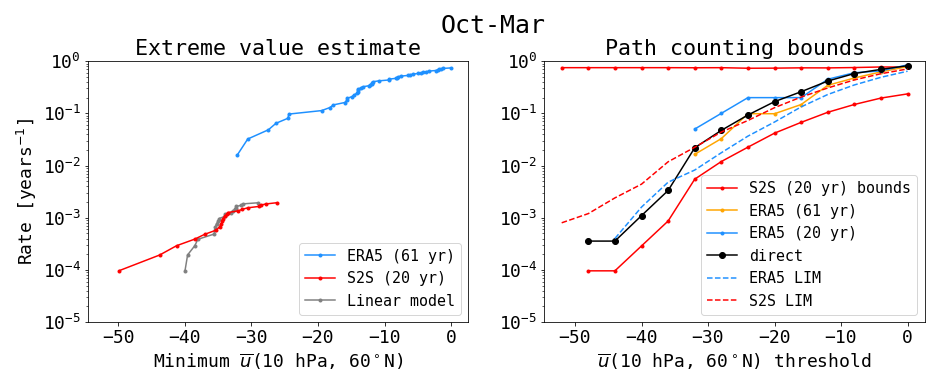

In [127]:
i_tth = 0
t_thresh = t_thresh_list[i_tth]
extval_stats = pickle.load(open(join(filedict["results"]["dir"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
rate_e5 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))

fig,axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True, sharex=True)
fig.set_facecolor("white")
axes[1].yaxis.set_tick_params(labelbottom=True)

# First plot: extreme values
ax = axes[0]
labels = {"e5": "ERA5 (61 yr)", "s2": "S2S (20 yr)", "linear_model": "Linear model"}
zorders = {"e5": 0, "s2": 1, "linear_model": -1}
handles = []
for src in ["e5","s2","linear_model"]:
    idx, = np.where(extval_stats[src]["umin"] < 0)
    order = np.argsort(extval_stats[src]["umin"][idx])
    h, = ax.plot(
        extval_stats[src]["umin"][idx][order], extval_stats[src]["rate_lower"][idx][order], 
        color=dispdict[src]["color"],
        marker='.', label=labels[src], zorder=zorders[src]
    ) 
    handles += [h]


ax.legend(handles=handles, fontsize="small", loc="lower right")
ax.set_xlabel("Minimum $\overline{u}$(10 hPa, 60$^\circ$N)")
ax.set_ylabel("Rate [years$^{-1}$]")
ax.set_yscale("log")
ax.set_title("Extreme value estimate")

# Second plot: rates
ax = axes[1]
handles = []
rate_s2 = rate_s2.where(rate_s2 > 0)
#colors = ["red", "purple", "orange"]
ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower"), color="red", marker='.')
h, = ax.plot(
    rate_s2["u_thresh"], rate_s2.sel(bound="upper"), 
    color="red", marker='.', label=r"S2S (20 yr) bounds"
)
handles += [h]
# Additionally plot ERA5 only
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), color="orange", marker='.', label="ERA5 (61 yr)")
handles += [h]
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), color="dodgerblue", marker='.', label="ERA5 (20 yr)")
handles += [h]

# Additionally plot Ed's estimate
h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed"), color="black", marker="o", label="direct")
handles += [h]

# Additionally plot the LIM estimate
for src in ["e5","s2"]:
    h, = ax.plot(
        rate_lim[src]["u_thresh"].values, 
        rate_lim[src].isel(i_tth=i_tth).values, color=dispdict[src]["color"], 
        linestyle='--', label=f"{dispdict[src]['abbrv']} LIM")
    handles += [h]



ax.set_yscale("log")
ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold")
ax.legend(handles=handles, fontsize="small")
ax.set_title("Path counting bounds")
ax.set_ylim([1e-5,1])

fig.subplots_adjust(top=0.85)
fig.suptitle(t_thresh_string_list[i_tth], y=0.98, fontsize=25)

In [ ]:
# Plot eigenvectors as a function of observable
eig = 2
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(15,12),sharey=True)
fig.subplots_adjust(top=0.9)
fig.suptitle(f"Eigenvalue {eig}: {lam[eig].real:.2f}+{lam[eig].imag:.2f}i", y=0.98, fontsize=25)
levels = np.array([10,100,500,850])
# First plot: zonal wind
ax = axes[0,0]
names = [f"ubar_{lev}_60_delay{d}" for d in [0] for lev in levels]
ax.barh([str(lev) for lev in levels], E.sel(eigenvector=eig, feature=names).real, color='dodgerblue')
ax.set_title("$\overline{u}$")
ax.axvline(0, color='black')
ax = axes[1,0]
names = [f"ubar_{lev}_60_delay{d}" for d in [0] for lev in levels]
ax.barh([str(lev) for lev in levels], E.sel(eigenvector=eig, feature=names).imag, color='red')
ax.set_title("$\overline{u}$")
ax.axvline(0, color='black')
# Second plot: heat flux wave 1
ax = axes[0,1]
xlim = [E.sel(feature=vT_1_names+vT_2_names).real.min(), E.sel(feature=vT_1_names+vT_2_names).real.max()]
names = [f"vT_{lev}_1_runavg10" for lev in levels]
ax.barh([str(lev) for lev in levels], E.sel(eigenvector=eig, feature=names).real, color='dodgerblue')
ax.set_title("$\overline{v'T'}$ wave 1")
ax.axvline(0, color='black')
ax.set_xlim(xlim)
ax = axes[1,1]
xlim = [E.sel(feature=vT_1_names+vT_2_names).real.min(), E.sel(feature=vT_1_names+vT_2_names).real.max()]
names = [f"vT_{lev}_1_runavg10" for lev in levels]
ax.barh([str(lev) for lev in levels], E.sel(eigenvector=eig, feature=names).imag, color='red')
ax.set_title("$\overline{v'T'}$ wave 1")
ax.axvline(0, color='black')
ax.set_xlim(xlim)
# Thir plot: heat flux wave 1
ax = axes[0,2]
names = [f"vT_{lev}_2_runavg10" for lev in levels]
ax.barh([str(lev) for lev in levels], E.sel(eigenvector=eig, feature=names).real, color='dodgerblue')
ax.set_title("$\overline{v'T'}$ wave 2")
ax.axvline(0, color='black')
ax.set_xlim(xlim)
ax = axes[1,2]
names = [f"vT_{lev}_2_runavg10" for lev in levels]
ax.barh([str(lev) for lev in levels], E.sel(eigenvector=eig, feature=names).imag, color='dodgerblue')
ax.set_title("$\overline{v'T'}$ wave 2")
ax.axvline(0, color='black')
ax.set_xlim(xlim)

# Method 3: DGA

In [ ]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [ ]:
if build_msm_flag:
    msm_feature_names = [f"ubar_10_60_delay{d}" for d in np.arange(max_delay)] 
    szn_stats_e5,msm_info = feat_strat.build_msm(
        max_delay, feat_all, feat_tpt, msm_feature_names, filedict["results"]["dir"], km_seed=43, num_clusters=num_clusters, 
    )

In [ ]:
szn_stats_e5.to_netcdf(join(filedict["results"]["dir"], "szn_stats_e5.nc"))

In [128]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [ ]:
if dga_flag:
    szn_stats_e5 = xr.open_dataset(join(filedict["results"]["dir"], "szn_stats_e5.nc"))
    msm_info = pickle.load(open(join(filedict["results"]["dir"], "msm_info"), "rb"))
    feat_strat.dga_from_msm(msm_info, feat_tpt, szn_stats_e5, t_thresh_list, u_thresh_list, filedict["results"]["dir"], clust_bndy_choice)

# Plot all the results together, regarding rates

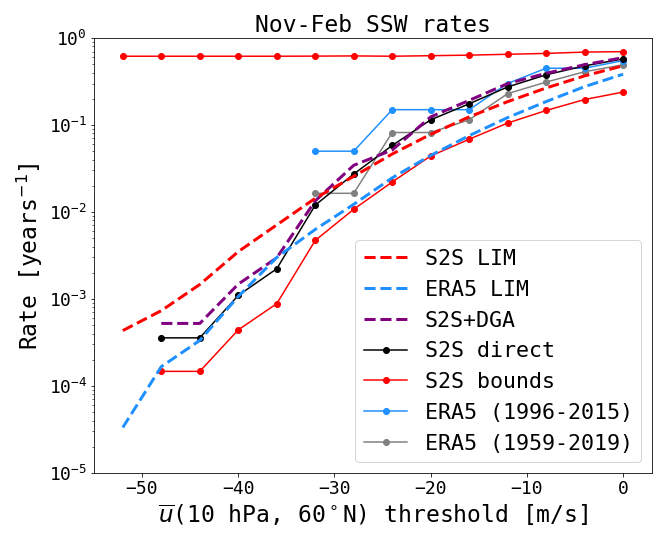

In [162]:
i_tth = 1
t_thresh = t_thresh_list[i_tth]

extval_stats = pickle.load(open(join(filedict["results"]["dir"], f"extval_stats_tth{t_thresh[0]}-{t_thresh[1]}"), "rb"))
rate_e5 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_e5_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = xr.open_dataarray(join(filedict["results"]["dir"], f"rate_pathcounting_s2_{t_thresh[0]}-{t_thresh[1]}.nc"))
rate_s2 = rate_s2.where(rate_s2 > 0)
dga_rates = pickle.load(open(join(filedict["results"]["dir"], f"dga_rates_{t_thresh[0]}-{t_thresh[1]}"), "rb"))["s2"]
dga_rates[dga_rates==0] = np.nan

fig,ax = plt.subplots(figsize=(10,8))
fig.set_facecolor("white")
handles = []
ax.set_yscale("log")
ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold [m/s]", fontsize=23)
ax.set_ylabel("Rate [years$^{-1}$]", fontsize=23)
ax.set_title(f"{t_thresh_string_list[i_tth]} SSW rates", fontsize=23)
ax.set_ylim([1e-5,1])
ax.set_xlim([u_thresh_list.min()-3, u_thresh_list.max()+3])
ax.set_xticks(np.arange(-50,1,10))

# --------------- Method 0: direct counting from ERA5 --------------
h, = ax.plot(
    rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1959-2019"), 
    color="gray", marker='o', label="ERA5 (1959-2019)"
)
handles = [h] + handles
h, = ax.plot(
    rate_e5["u_thresh"], rate_e5.where(rate_e5>0).sel(falls="1996-2015"), 
    color="dodgerblue", marker='o', label="ERA5 (1996-2015)"
)
handles = [h] + handles
ax.legend(handles=handles, fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["dir"], f"results_itth{i_tth}_0"), bbox_inches="tight")

# --------------- Method 1: upper and lower bounds from S2S ---------
ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="lower"), color="red", marker='o')
h, = ax.plot(
    rate_s2["u_thresh"], rate_s2.sel(bound="upper"), 
    color="red", marker='o', label=r"S2S bounds"
)
handles = [h] + handles
ax.legend(handles=handles, fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["dir"], f"results_itth{i_tth}_1"), bbox_inches="tight")

# --------------- Method 2: direct estimate from S2S --------------
# Additionally plot Ed's estimate
h, = ax.plot(rate_s2["u_thresh"], rate_s2.sel(bound="ed"), color="black", marker="o", label="S2S direct")
handles = [h] + handles
ax.legend(handles=handles, fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["dir"], f"results_itth{i_tth}_2"), bbox_inches="tight")


# ---------------------- Method 3: DGA -----------------------------
h, = ax.plot(u_thresh_list, dga_rates, color='purple', linestyle='--', 
             linewidth=3, label="S2S+DGA")
handles = [h] + handles
ax.legend(handles=handles, fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["dir"], f"results_itth{i_tth}_3"), bbox_inches="tight")

# ----------------------- Method 4: LIM -----------------------------
for src in ["e5","s2"]:
    h, = ax.plot(
        rate_lim[src]["u_thresh"].values, 
        rate_lim[src].isel(i_tth=i_tth).values, color=dispdict[src]["color"], 
        linestyle='--', linewidth=3, label=f"{dispdict[src]['abbrv']} LIM")
    handles = [h] + handles
ax.legend(handles=handles, fontsize="large", loc="lower right")
fig.savefig(join(filedict["results"]["dir"], f"results_itth{i_tth}_4"), bbox_inches="tight")




In [151]:
filedict["results"]["dir"]

'/scratch/jf4241/ecmwf_data/results/tpt_quantities/2022-09-25/del15_cls170_bdyhalf_featset1'

## Plot some pictures of the committor 

In [ ]:
reload(tpt_utils)
reload(feature_template)
reload(feature_stratosphere)
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
plt.rcParams.update({"font.size": 18, "font.family": "monospace"})

In [ ]:
i_tth = 0
i_uth = 13
t_thresh = t_thresh_list[i_tth]
u_thresh = u_thresh_list[i_uth]

dga_results = pickle.load(open(join(filedict["results"]["dir"], f"dga_results_s2_{t_thresh[0]}-{t_thresh[1]}_u{u_thresh}"), "rb"))
szn_stats_e5 = xr.open_dataset(join(filedict["results"]["dir"], "szn_stats_e5.nc"))
msm_info = pickle.load(open(join(filedict["results"]["dir"], "msm_info"), "rb"))

feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], u_thresh)
ab_tag_e5 = feat_strat.ab_test(feat_tpt["e5"])
cej_e5 = feat_strat.cotton_eye_joe(feat_tpt["e5"], ab_tag_e5, "timechunks")
comm_e5 = feat_strat.estimate_empirical_committor(cej_e5)

In [ ]:
qp = dict({
    "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qp"]), "e5": comm_e5.sel(sense="until"),
})
qm = dict({
    "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["qm"]), "e5": comm_e5.sel(sense="since"),
})
pi = dict({
    "s2": feat_strat.broadcast_field_msm2dataarray(msm_info["s2"], dga_results["pi"], density_flag=True), "e5": xr.ones_like(qm["e5"]),
})

In [ ]:
combo = 3
if combo == 0:
    feat_names = ["ubar_100_60_delay0","ubar_500_60_delay0"]
    t_bounds = t_thresh[0], t_thresh[0]+50
elif combo == 1:
    feat_names = ["ubar_100_60_delay0","ubar_500_60_delay0"]
    t_bounds = t_thresh[0]+50, t_thresh[0]+100
elif combo == 2:
    feat_names = ["ubar_100_60_delay0","ubar_500_60_delay0"]
    t_bounds = t_thresh[0]+100, t_thresh[0]+150
elif combo == 3:
    feat_names = ["ubar_100_60_delay0","ubar_500_60_delay0"]
    t_bounds = t_thresh[0]+150, t_thresh[0]+200    
elif combo == 4:
    feat_names = ["t_szn","ubar_10_60_delay0"]
    t_bounds = t_thresh[0], t_thresh[1]   
elif combo == 5:
    feat_names = ["t_szn","ubar_500_60_delay0"]
    t_bounds = t_thresh[0], t_thresh[1]  
elif combo == 6:
    feat_names = ["t_szn","ubar_100_60_delay0"]
    t_bounds = t_thresh[0], t_thresh[1]  

    
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(16,12), sharey=True, sharex=True)
fig.suptitle(f"Days {t_bounds[0]}-{t_bounds[1]}")
fig.set_facecolor('white')
for i_src, src in enumerate(["e5","s2"]):
    # Two committors to plot: one according to ERA5, and one according to S2S 
    stackmap = {"sample": ("t_init","member","t_sim")}
    field = qp[src].stack(stackmap).to_numpy().flatten()
    weight = pi[src].stack(stackmap).to_numpy().flatten()
    cond = (feat_tpt[src].sel(feature="t_szn") > t_bounds[0]) * (feat_tpt[src].sel(feature="t_szn") < t_bounds[1])
    features = np.array([
        feat_tpt[src].where(cond).sel(feature=feat_names[0]).stack(stackmap).to_numpy().flatten(),
        feat_tpt[src].where(cond).sel(feature=feat_names[1]).stack(stackmap).to_numpy().flatten()
    ]).T
    
    ax = axes[0,i_src]
    tpt_utils.plot_field_2d(
        field, weight, features, fig=fig, ax=ax, feat_names=feat_names, 
        stat_name="mean", 
        vmin=0, vmax=1, shp=[30,30], cmap=plt.cm.coolwarm
    )
    ax.set_title(f"{dispdict[src]['abbrv']} Committor")

    ax = axes[1,i_src]
    tpt_utils.plot_field_2d(
        field, weight, features, fig=fig, ax=ax, feat_names=feat_names, 
        stat_name="weightsum", 
        vmin=None, vmax=None, logscale=True, cmap=plt.cm.magma
    )
    ax.set_title("Density")
    # Modify x ticks if the horizontal axis is t_szn
    if feat_names[0] == "t_szn":
        xticks, xticklabels = feat_strat.generate_seasonal_xticks(features[:,0])
        axes[1,i_src].set_xticks(xticks)
        axes[1,i_src].set_xticklabels(xticklabels)


### Do a sparse linear regression on the features at a certain slice of time

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression

In [ ]:
src = "s2"
stackmap = {"sample": ("t_init","member","t_sim")}
committor = qp[src].stack(stackmap)
feat_names = [f"ubar_{p}_60_delay{d}" for p in [500] for d in range(10)]
predictors = feat_tpt[src].sel(feature=feat_names+["t_szn"]).stack(stackmap).transpose("sample","feature")

In [ ]:
# Clean and subset data
idx, = np.where(
    (np.isnan(predictors).sum(axis=1) == 0) * 
    (np.isnan(committor) == 0) * 
    # (committor > 0.52) * (committor < 0.522) * 
    (predictors.sel(feature="t_szn") > t_thresh[0]) * (predictors.sel(feature="t_szn") < t_thresh[0]+170)
)
X = predictors.sel(feature=feat_names).to_numpy()[idx]
y = committor[idx]

In [ ]:
_ = plt.hist(y, bins=100)

In [ ]:
# Normalize features
X = StandardScaler().fit_transform(X)

In [ ]:
# Split into train, test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Fit the lasso
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f"Train score: {reg.score(X_train,y_train)*100}. Test score: {reg.score(X_test,y_test)*100}")

In [ ]:
plt.plot(reg.coef_, marker='o')

# Picking good coordinates 

To find good features for DGA, we should get as much as we can out of reanalysis, such as approximate committors or correlates with the extreme values. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression

In [ ]:
# Choose a specific time window
i_tth = 0
t_thresh = t_thresh_list[i_tth]

In [ ]:
# Compute minimum u between a time point and the end of winter
fy_evs = extval_stats["e5"]["fall_years"]
umin2come = np.nan*np.ones(feat_tpt["e5"].t_sim.size)
for i_yr in range(len(fy_evs)):
    idx = np.sort(np.where(
        (
            (feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == fy_evs[i_yr]) * 
            (feat_tpt["e5"].sel(feature="t_szn") >= t_thresh[0]) * 
            (feat_tpt["e5"].sel(feature="t_szn") < t_thresh[1])
        ).to_numpy().flatten()
    )[0])
    umin2come[idx] = np.minimum.accumulate(
        feat_tpt["e5"].sel(feature="ubar_10_60_delay0").to_numpy().flatten()[idx][::-1]
    )[::-1]

In [ ]:
# Select a time window for regression
t0,t1 = t_thresh[0] + np.array([0,1])

In [ ]:
stackmap = {"sample": ("t_init","member","t_sim")}
cond = (
    (feat_all["e5"]["time_observable"].sel(feature="t_szn") >= t0) * 
    (feat_all["e5"]["time_observable"].sel(feature="t_szn") < t1)
)
predictors = feat_tpt["e5"].where(cond).stack(stackmap).transpose("sample","feature")

In [ ]:
# Select some features by hand
feature_names = (
    []
    + [f"ubar_{p}_60_delay{d}" for p in [10,100,500,850] for d in range(max_delay)] 
    + [f"vT_{p}_1_runavg{d}" for p in [10,100,500,850] for d in range(max_delay)]
    + [f"vT_{p}_2_runavg{d}" for p in [10,100,500,850] for d in range(max_delay)]
    + [f"ubar_{p}_0pm5" for p in [10,100]]
)
X = predictors.sel(feature=feature_names).to_numpy()
z = umin2come.copy()
good_idx, = np.where(np.all(np.isfinite(X), axis=1))
X = X[good_idx]
z = z[good_idx]

### Sparse regression of the annual minimum as a function of early-winter conditions

In [ ]:
# Clean and normalize data
X = StandardScaler().fit_transform(X)
# Split into training and testing
holdout = 0
if holdout:
    X_train,X_test,z_train,z_test = train_test_split(X,z,test_size=0.25, random_state=3)
else:
    X_train = X
    X_test = X
    z_train = z
    z_test = z


In [ ]:
alpha_list = np.arange(0.1,1.6,0.1)
Nalpha = len(alpha_list)
test_score_list = np.nan*np.ones(Nalpha)
train_score_list = np.nan*np.ones(Nalpha)
coeffs = np.zeros((Nalpha,len(feature_names)))
intercepts = np.zeros(Nalpha)
for i_a in range(Nalpha):
    reg = Lasso(alpha=alpha_list[i_a],max_iter=5000).fit(X_train,z_train)
    coeffs[i_a] = reg.coef_
    intercepts[i_a] = reg.intercept_
    test_score_list[i_a] = reg.score(X_test,z_test)
    train_score_list[i_a] = reg.score(X_train,z_train)


In [ ]:
# Correlation coefficient
corr = (z - z.mean()) @ (X - X.mean(axis=0)) / (len(z) * np.std(z) * np.std(X, axis=0))
fig,ax = plt.subplots()
ax.scatter(corr, coeffs[-1], color='black', marker='.')
ax.set_xlabel("Correlation coefficient")
ax.set_ylabel("LASSO weight")

In [ ]:
fig,ax = plt.subplots()
for i_feat in range(len(feature_names)):
    ax.plot(alpha_list, coeffs[:,i_feat])

In [ ]:
fig,axes = plt.subplots(nrows=2,figsize=(5,12))
ax = axes[0]
sparsity_list = np.mean(coeffs==0, axis=1)
i_a_cutoff = np.where(alpha_list > 0.55)[0][0]
sig_flag = (np.max(np.abs(coeffs[i_a_cutoff:]), axis=0) > 0)
handles = []
for i_feat in range(len(feature_names)):
    if sig_flag[i_feat]:
        color = None
        if feature_names[i_feat].startswith("ubar"):
            color = "red"
        elif feature_names[i_feat].startswith("vT"):
            color = "black"
        h, = ax.plot(alpha_list, coeffs[:,i_feat],label=feature_names[i_feat], color=color)
        handles += [h]
ax.legend(handles=handles, fontsize="xx-small",bbox_to_anchor=(1.6,1.0))
ax.set_ylabel("Coeff")
ax = axes[1]
hsc, = ax.plot(alpha_list, test_score_list, color='black', marker='.',label="Score")
hsp, = ax.plot(alpha_list, sparsity_list, color='red', marker='.',label="Sparsity")
ax.legend(handles=[hsc,hsp],bbox_to_anchor=(1.6,0.5))
ax.set_xlabel("L1 penalty")
ax.set_ylim([0,1])

In [ ]:
sig_feature_idx, = np.where(np.max(np.abs(coeffs[i_a_cutoff:,:]), axis=0) > 0)
sig_feature_names = [feature_names[i] for i in sig_feature_idx]
if 'ubar_10_60_delay0' not in sig_feature_names:
    sig_feature_names += ["ubar_10_60_delay0"]

In [ ]:
fig,ax = plt.subplots()
zpred = intercepts[i_a_cutoff] + X_test @ coeffs[i_a_cutoff]
ax.scatter(zpred,z_test,marker='.')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
xlim = min(zpred.min(),z.min()), max(zpred.max(),z.max())
ax.plot(xlim,xlim,color='gray')